# A10 Q2: Adversarial Attacks

In [350]:
# Standard imports
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

In [351]:
# In case you are fortunate enough to have access to a GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset: flattened MNIST

In [352]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [353]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [354]:
def draw(x):
    '''Displays a flattened MNIST digit'''
    with torch.no_grad():
        plt.imshow(x.cpu().numpy().reshape((img_size,img_size)), cmap='gray');
        plt.axis('off');

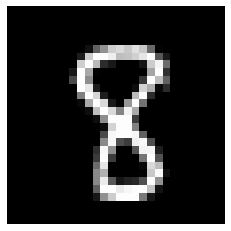

In [355]:
x,t = ds_full.__getitem__(50001)
draw(x)

In [356]:
ds = ds_full
#ds = torch.utils.data.Subset(ds_full, range(1024))

# Obtain trained network
You can train the network yourself. However, if you would rather skip that part, a pre-trained network is supplied. That is what will be run by default.

In [357]:
class MyNet(nn.Module):
    '''
     net = MyNet(img_size=28)
     
     Creates a neural network to do classification on MNIST.
     It assumes the images will be (img_size)x(img_size).
     
     The output of the network is the log of the 10 class probabilities
     (ie. log-softmax). Correspondingly, this network uses the
     negative log-likelihood loss function (nn.NLLLoss).
    '''
    def __init__(self, img_size=28):
        super().__init__()
        self.lyrs = nn.Sequential(
            nn.Linear(img_size**2, 100), nn.ReLU(),
            nn.Linear(100, 10), nn.LogSoftmax(dim=-1),
            )
        self.loss_fcn = nn.NLLLoss()
        self.losses = []
        self.to(device)
        
        
    def forward(self, x):
        return self.lyrs(x)
    
    
    def learn(self, dl, optimizer=None, epochs=10):
        '''
         net.learn(dl, optimizer=None, epochs=10)
         
         Train the network on the dataset represented by the DataLoader dl.
         The default optimizer is Adam().
         
         The targets for the dataset are assumed to be class indices.
        '''
        if optimizer is None:
            print('Need to specify an optimizer and loss function')
            return
        
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                x = x.to(device)   # for use with a GPU
                t = t.to(device)
                x.requires_grad = True
                y = self(x)
                loss = self.loss_fcn(y, t)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.detach().numpy()
                count += 1.
            self.losses.append(total_loss/len(dl))
            #print(f'Epoch: {epoch}, loss: {total_loss/count}')
        plt.figure(figsize=(4,4))
        plt.plot(self.losses); plt.yscale('log');

In [358]:
net = MyNet(img_size)

In [359]:
# Uncomment these lines if you want to train it yourself.
#dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)
#net.learn(dl, optimizer=torch.optim.Adam(net.parameters(), lr=0.001), epochs=200)

In [360]:
# Uncomment this line to save your network.
#torch.save(net.cpu(), 'mnist_trained.pt')

In [361]:
# Use the line below to load a pre-trained network from a file.
# Note that the MyNet class should be defined first.
net = torch.load('mnist_trained.pt').to(device)
net

MyNet(
  (lyrs): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): LogSoftmax(dim=-1)
  )
  (loss_fcn): NLLLoss()
)

In [362]:
a=torch.tensor([[1,2,9],[4,3,5]])
print(a)
def getTarget(x):
    if(x==9):
        return 0
    return x+1
b=a.apply_(getTarget)
print(b)

tensor([[1, 2, 9],
        [4, 3, 5]])
tensor([[2, 3, 0],
        [5, 4, 6]])


Accuracy = 97.82%


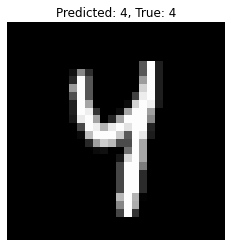

In [363]:
# If you'd like some confidence that the network is well trained, you can
# test its accuracy.
# The supplied network should have a test accuracy over 97%.

def accuracy(net, dl):
    total_correct = 0.
    for x,t in dl:
        y = net(x.to(device))
        blah = torch.argmax(y.cpu(), dim=1)
        total_correct += torch.sum(blah==t).cpu().item()
    return total_correct/len(dl.dataset)

dl_test = torch.utils.data.DataLoader(ds_test, batch_size=256)
acc = accuracy(net, dl_test)
print(f'Accuracy = {acc*100.:0.2f}%')

# Classify a random digit
idx = np.random.randint(len(ds_test))
x, t = ds_test.__getitem__(idx)
x.requires_grad = True
y = net(x)
loss = net.loss_fcn(y, torch.tensor(t))
#loss.zero_grad()
#print(x.grad)
loss.backward()
#print(x.grad)
draw(x)
plt.title(f'Predicted: {torch.argmax(y).detach().numpy()}, True: {t}');


# A. `fgsm` Method

In [364]:
def fgsm(net, x, t, eps=0.01, targ=False):
    '''
        x_adv = FGSM(net, x, t, eps=0.01, targ=False)
        
        Performs the Fast Gradient Sign Method, perturbing each input by
        eps (in infinity norm) in an attempt to have it misclassified.
        
        Inputs:
          net    PyTorch Module object
          x      (D,I) tensor containing a batch of D inputs
          t      tensor of D corresponding class indices
          eps    the maximum infinity-norm perturbation from the input
          targ   Boolean, indicating if the FGSM is targetted
                   - if targ is False, then t is considered to be the true
                     class of the input, and FGSM will work to increase the cost
                     for that target
                   - if targ is True, then t is considered to be the target
                     class for the perturbation, and FGSM will work to decrease the
                     cost of the output for that target class
        
        Output:
          x_adv  tensor of a batch of adversarial inputs, the same size as x
    '''

    # You probably want to create a copy of x so you can work with it.
    x_cpy = x.clone().to(device)
    x_cpy.requires_grad = True
    
    #===== YOUR CODE HERE =====
    def getTarget(x):
        # if original target is i, for targetted attack, we set new target
        # to i+1, if i==9, the new target is 0
        if(x==9):
            return 0
        return x+1

    if (targ):
        y = net(x_cpy)
        t_cpy = t.clone().to(device)
        newTarget = t_cpy.apply_(getTarget)
        loss_cpy = net.loss_fcn( y ,  newTarget )
        loss_cpy.backward()
        x_grad = x_cpy.grad
        return x_cpy - torch.sign(x_grad) * eps
    else:
        loss_cpy = net.loss_fcn( net(x_cpy),  t  )
        loss_cpy.backward()
        x_grad = x_cpy.grad
        return x_cpy + torch.sign(x_grad) * eps
        

# B. Untargetted Adversarial Attack

torch.Size([10, 784])


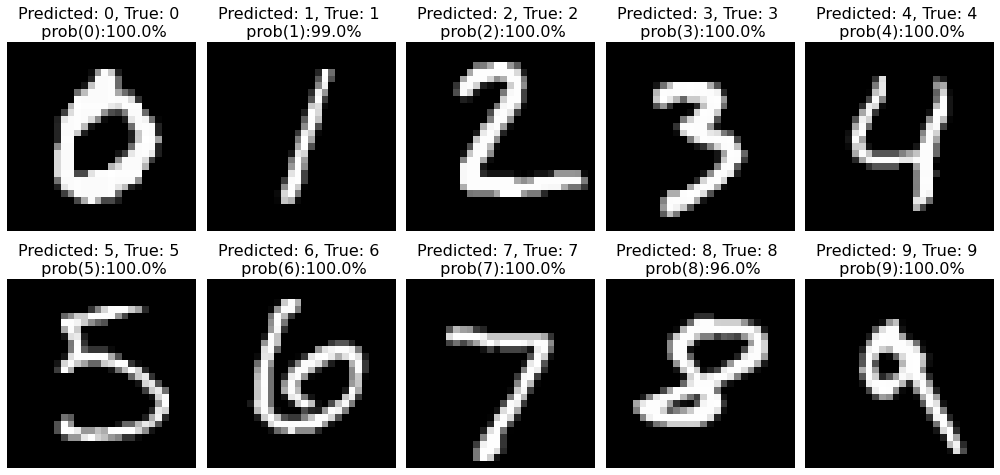

In [365]:
# Create a batch consisting of one correctly-classified digit
# from each class.
x_batch = torch.tensor([])
# we discover for first 3 and first 5, the handwritten is not good
# so we skip those numbers and use the 2nd 3 and 2nd 5
skip_three = True
skip_five = True
for i in range(10):
    for x_temp,t_temp in ds_test:
        if (t_temp==i):
            if(skip_three and i==3):
                skip_three = False
                continue
            if (skip_five and i==5):
                skip_five = False
                continue
            x_batch = torch.cat((x_batch, x_temp))
            break

x = torch.reshape(x_batch, (10,784))
print(x.shape)

t = torch.arange(start=0, end=10)
plt.figure(figsize=(14,7))

# draw x
for n,xx in enumerate(x):    
    plt.subplot(2,5,n+1); draw(xx);
    y = net(xx)
    pred = torch.argmax(y)
    target_prob = torch.exp(y[n])/sum(torch.exp(y))
    plt.title(f'Predicted: {pred.detach().numpy()}, True: {n} \n prob({n}):{torch.round(target_prob*100)}%', fontsize=16)
plt.tight_layout()

In [366]:
# Call fgsm on that batch
x_adv = fgsm(net, x, t, eps=0.05, targ=False)

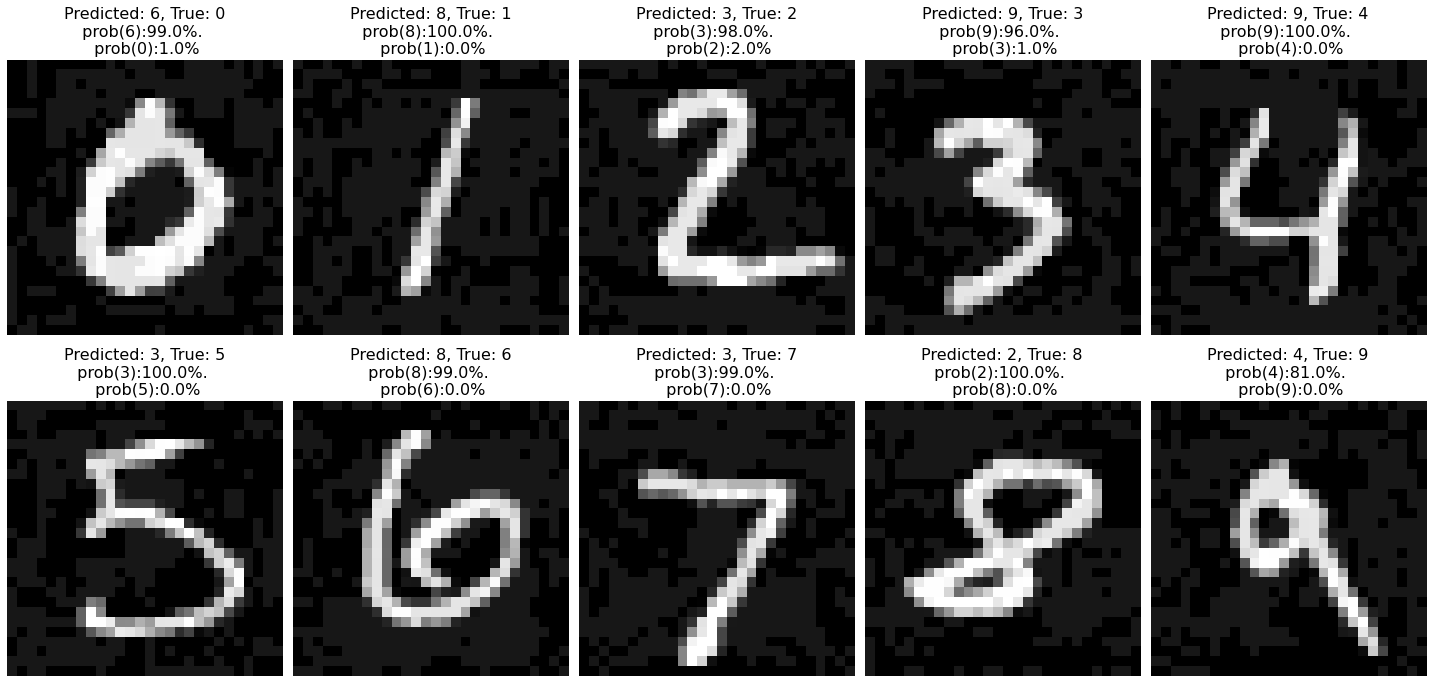

In [367]:
# Display all 10 digits, including the true class/probability,
# and the predicted class/probability.






plt.figure(figsize=(20,10))
for n,xx in enumerate(x_adv):    
    plt.subplot(2,5,n+1); draw(xx);
    y = net(xx)
    pred = torch.argmax(y)
    max_prob = torch.exp(y[pred])/sum(torch.exp(y))
    target_prob = torch.exp(y[n])/sum(torch.exp(y))
    plt.title(f'Predicted: {pred.detach().numpy()}, True: {n}\n prob({pred}):{torch.round(100*max_prob)}%.  \n prob({n}):{torch.round(100*target_prob)}%', fontsize=16)
plt.tight_layout()




# C. Targetted Adversarial Attack

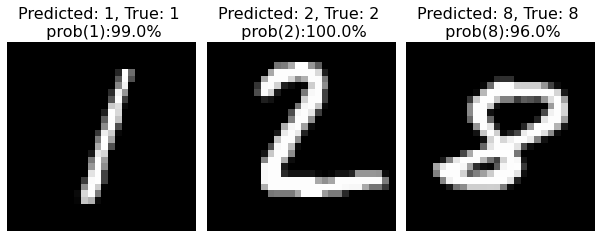

In [368]:
# Targetted Adversarial Attack
# Choose 3 inputs (different classes)
x_batch = torch.tensor([])
t = torch.tensor([1,2,8])
for i in [1,2,8]:
    for x_temp,t_temp in ds_test:
        if (t_temp==i):
            x_batch = torch.cat((x_batch, x_temp))
            break

x = torch.reshape(x_batch, (3,784))

plt.figure(figsize=(14,7))
for n,xx in enumerate(x):    
    plt.subplot(2,5,n+1); draw(xx);
    y = net(xx)
    pred = torch.argmax(y)
    target_prob = torch.exp(y[t[n]])/sum(torch.exp(y))
    plt.title(f'Predicted: {pred.detach().numpy()}, True: {t[n]} \n prob({t[n]}):{torch.round(target_prob*100)}%', fontsize=16)
plt.tight_layout()


x_adv = fgsm(net, x, t, eps=0.05, targ=True)

<Figure size 1008x504 with 0 Axes>

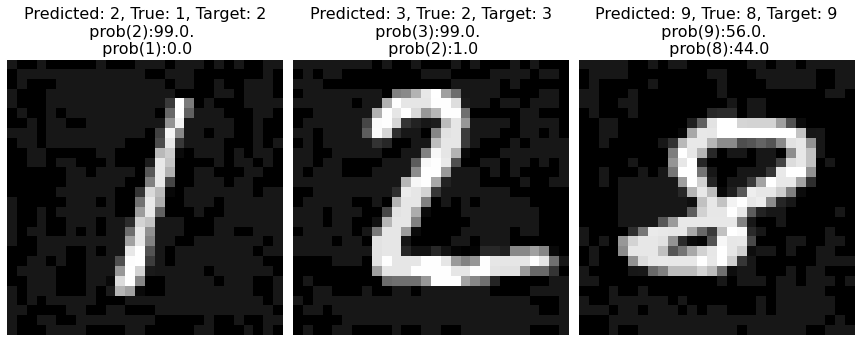

In [370]:
plt.figure(figsize=(14,7))
ind=0

plt.figure(figsize=(20,10))
for n,xx in enumerate(x_adv):    
    plt.subplot(2,5,n+1); draw(xx);
    y = net(xx)
    pred = torch.argmax(y)
    max_prob = torch.exp(y[pred])/sum(torch.exp(y))
    target_prob = torch.exp(y[t[n]])/sum(torch.exp(y))
    plt.title(f'Predicted: {pred.detach().numpy()}, True: {t[n]}, Target: {getTarget(t[n])}\n prob({pred}):{torch.round(100*max_prob)}.  \n prob({t[n]}):{torch.round(100*target_prob)}', fontsize=16)
plt.tight_layout()
